# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
import torchvision
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt
import numpy as np
import shutil
from tqdm import tqdm
import random
import numpy as np
import cv2
from skimage.util import view_as_windows
from sklearn.feature_extraction import image as image_skl
from scipy.ndimage import rotate

# Loading CIFAR10 dataset

In [2]:
def separate():
    print('-'*120)

In [3]:
# set device for torch 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# data augment by random crops for training
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data_cifar', train=True,
                                        download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(root='./data_cifar', train=False,
                                       download=True, transform=transform_test)

batch_size = 128

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=batch_size,
                                         shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# definition of the original classes
classes_org = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
# choose a picture at random
im_minibatch, label_minibatch = next(iter(testloader))
im, label = im_minibatch[0].cpu(), label_minibatch[0].cpu()

# store image size dimensions
image_size = tuple(im.shape)

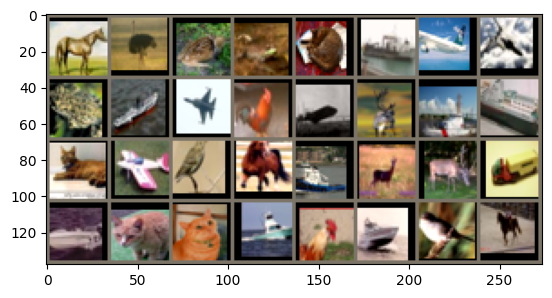

horse bird  deer  frog  cat   ship  plane plane frog  ship  plane bird  plane deer  ship  ship  cat   plane bird  horse ship  deer  deer  truck ship  cat   cat   ship  bird  ship  bird  horse


In [7]:
# function to show an image
def show(X):    
    if isinstance(X, np.ndarray):
        X = torch.Tensor(X)
                
    X = inverse_transform(X)

    # Clip to valid range for floats
    rgb_data = np.clip(X.numpy(), 0, 1)

    # Clip to valid range for integers
    rgb_data = np.clip(rgb_data, 0, 255)
    
    plt.imshow(np.transpose(rgb_data, (1, 2, 0)))

    #import imageio
    #imageio.imwrite('image.png', np.transpose(rgb_data, (1, 2, 0)))
    
    plt.show()
    
inverse_transform = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), 
                                        transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),])

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
show(torchvision.utils.make_grid(images[0:32]))

# print their labels
print(' '.join(f'{classes_org[labels[j]]:5s}' for j in range(batch_size//4)))

# 1. Model preparation

# 1.1. Loading MobileNetV2 model

In [8]:
# function for loading the PyTorch MobileNetV2 model with given number of outputs
def load_model(classes):
    model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False)

    # Replace the final fully-connected layer with length of classes (outputs)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = torch.nn.Linear(num_ftrs, len(classes))
    
    return model

In [9]:
%%capture
model_org = load_model(classes_org)
model_org.to(device)

## 1.2. Training (do not train as it was done and weights are already available)

In [884]:
# function for training the model given the model, dataset and weight directory where they are saved
def train_model(model, trainloader, testloader, weights_dir, num_epochs=100):
    start=time.time()
    
    error = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(0,num_epochs):

        model.train()  # Put the network in train mode
        for i, (x_batch, y_batch) in enumerate(trainloader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move the data to the device that is used

            optimizer.zero_grad()  # Set all currenly stored gradients to zero 

            y_pred = model(x_batch)

            loss = error(y_pred, y_batch)

            loss.backward()

            optimizer.step()

            # Compute relevant metrics

            y_pred_max = torch.argmax(y_pred, dim=1)  # Get the labels with highest output probability

            correct = torch.sum(torch.eq(y_pred_max, y_batch)).item()  # Count how many are equal to the true labels

            elapsed = time.time() - start  # Keep track of how much time has elapsed

            # Show progress every 20 batches 
            if not i % 20:
                print(f'epoch: {epoch}, time: {elapsed:.3f}s, loss: {loss.item():.3f}, train accuracy: {correct / batch_size:.3f}')

        correct_total = 0

        model.eval()  # Put the network in eval mode
        for i, (x_batch, y_batch) in enumerate(testloader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move the data to the device that is used

            y_pred = model(x_batch)
            y_pred_max = torch.argmax(y_pred, dim=1)

            correct_total += torch.sum(torch.eq(y_pred_max, y_batch)).item()

        print(f'Accuracy on the test set: {correct_total / len(testset):.3f}')

        # Save weights every 10 epochs
        if epoch%10==0:
            torch.save(model.state_dict(), f"./{weights_dir}/epoch-{epoch}_accuracy-{correct_total/len(testset):.3f}.pth")
    

In [10]:
# delete the directory of weights if it already exists and then create it
if os.path.exists(os.path.join('weights')):
    shutil.rmtree(os.path.join('weights'))
!mkdir weights2

In [ ]:
train_model(model_org, trainloader, testloader, 'weights')

## 1.3. Load latest weights

In [10]:
# function for loaduing weights of a trained model
def load_weights(classes, model, weights_dir):
    files = os.listdir(weights_dir)
    weight_paths = [os.path.join(weights_dir, basename) for basename in files]
    # get the latest file in the directory
    final_weight_file = os.path.basename(max(weight_paths, key=os.path.getctime))

    # first model needs to be loaded
    model = load_model(classes)

    # fixes odd error when state_dict has prescript "model."" in keys
    state_dict = torch.load(os.path.join(weights_dir, final_weight_file), map_location=device)
    for key in list(state_dict.keys()):
        if key.startswith("model."):
            state_dict[key[6:]] = state_dict.pop(key)
    model.load_state_dict(state_dict)

    print('Loaded weights: ' + final_weight_file)
    
    return model

In [11]:
# load trained model weights for the original model
model_org = load_weights(classes_org, model_org, 'weights')

Loaded weights: epoch-90_accuracy-0.842.pth


Using cache found in C:\Users\raulv/.cache\torch\hub\pytorch_vision_v0.10.0


In [12]:
%%capture
model_org.to(device)
model_org.eval()

## 1.4. Evaluation

In [13]:
# function that visualizes how given model gives predictions based on a few examples
def show_examples(classes, testloader, model):
    dataiter = iter(testloader)
    images, labels = next(dataiter)

    # show images
    show(torchvision.utils.make_grid(images[:16]))
    print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(16)))

    images = images.to(device)
    outputs = model(images)

    # get prediction labels
    _, predicted = torch.max(outputs, 1)

    separate()
    print('Predicted:   ', ' '.join(f'{classes[predicted[j]]:5s}'
                                  for j in range(16)))

In [14]:
# function that shows test accuracy of the model for each class and then combined
def show_accuracies(classes, testloader, model):
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # again no gradients needed
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    accuracy_list = []
    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        accuracy_list.append(accuracy)
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

    # print total accuracy
    separate()
    print(f'Accuracy on the test set: {round(np.mean(accuracy_list),1)}%')


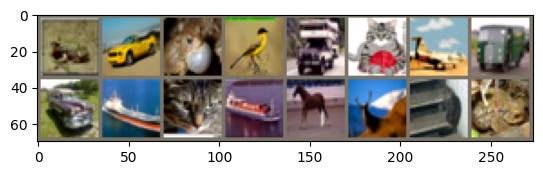

GroundTruth:  frog  car   frog  bird  truck cat   plane truck car   ship  cat   ship  horse deer  cat   frog 
------------------------------------------------------------------------------------------------------------------------
Predicted:    frog  car   cat   bird  truck cat   plane truck car   ship  cat   ship  horse deer  bird  frog 


In [15]:
show_examples(classes_org, testloader, model_org)

In [16]:
show_accuracies(classes_org, testloader, model_org)

Accuracy for class: plane is 87.1 %
Accuracy for class: car   is 91.9 %
Accuracy for class: bird  is 77.5 %
Accuracy for class: cat   is 65.6 %
Accuracy for class: deer  is 83.2 %
Accuracy for class: dog   is 79.6 %
Accuracy for class: frog  is 90.5 %
Accuracy for class: horse is 84.2 %
Accuracy for class: ship  is 90.4 %
Accuracy for class: truck is 91.7 %
------------------------------------------------------------------------------------------------------------------------
Accuracy on the test set: 84.2%


# 2. Adversarial attack

In [16]:
# motivated by/adapted from https://medium.com/analytics-vidhya/adversarial-attack-using-genetic-algorithm-90beba13b6cb
class GeneticAlgorithm:
    def __init__(self, model, im_size, start_population=None, pop_size=100, best_pop_percent=0.8, random_pop_percent=0.05, mutation_rate=0.05,
                 print_results=False, early_stopping=True, num_gen_no_change=50):
        self.model = model                                  # model which GA will attack
        self.im_size = im_size      
        self.start_population = start_population            # does GA need to mimick a certain image? then it is set as start population
        self.pop_size = pop_size
        self.best_pop_percent = best_pop_percent            # top % which will be saved for next generation
        self.random_pop_percent = random_pop_percent        # % of randomly added population members
        self.mutation_rate = mutation_rate                  # rate at which children mutate
        self.print_results = print_results                  # show scores generated by GA for given generation number
        self.early_stopping = early_stopping                # if not much improvement is detected, stop
        self.num_gen_no_change = num_gen_no_change          # how many geneartions without change before early stopping


    def optimize(self, fitness_fn, adv_target, num_of_gen, print_interval):
        self.adv_target = adv_target                        # class of adversarial target for targeted attack
        
        if self.start_population is not None:               # if image is given as starting population -> load it
            self.population = self.load_population()
        else:                                               # else create a random population
            self.population = self.initial_population()
    
        # preallocation
        results = np.zeros(len(self.population))
        prev_results = np.zeros(len(self.population))
        no_change_count = 0

        for gen in range(num_of_gen):
            self.population, results = self.evolve(fitness_fn)      # evolve based on fitness function

            # count number of generations with no change for early stopping if needed
            if np.isclose(prev_results[:10], results[:10]).all():   
                no_change_count += 1
            else:
                no_change_count = 0
                prev_results = results
            
            if self.print_results:
                if gen == 0:
                    print("Generation #: best result")
                elif gen == num_of_gen - 1:
                    print("Generation ", gen, ": ", results[0])
                elif gen % print_interval == 0:
                    print("Generation ", gen, ": ", results[0])
                    
            # early stopping
            if np.isclose(results[:10], 1).any() or (self.early_stopping and no_change_count >= self.num_gen_no_change):
                if self.print_results:
                    print("Early exit on iteration ", gen, " with best result ", results[0])
                break

        # after optimal population is found, return it
        return self.population[0]
    
    # loading initial population
    def load_population(self):
        return np.array([self.start_population.numpy() for _ in range(self.pop_size)])

    # creating initial population of individual solutions 
    def initial_population(self):
        return np.random.rand(self.pop_size, *self.im_size)

    # evolving the population to the next generation
    def evolve(self, fitness_fn):
        # evaluate current population based on fitness function
        scores = self.evaluate_population(self.population, fitness_fn)

        # save best candidates
        elite_size = int(self.best_pop_percent * self.pop_size)
        elite_indices = np.argsort(scores)[-elite_size:]
        elite = [self.population[i] for i in elite_indices]

        # save some random candidates
        random_size = int(self.random_pop_percent * self.pop_size)
        random_indices = np.random.randint(0, self.pop_size, random_size)
        random_population = [self.population[i] for i in random_indices]

        # generate children based on 2 parents
        children = []
        while len(children) < self.pop_size - elite_size - random_size:
            # select random parents
            parent1_idx, parent2_idx = np.random.randint(0, elite_size - random_size - 1, 2)
            parent1 = self.population[parent1_idx]
            parent2 = self.population[parent2_idx]
            
            # create a child using crossover of two parents
            child = self.crossover(parent1, parent2)

            # randomly mutate a child with given probability
            if np.random.random() < self.mutation_rate:
                child = self.mutate(child)
            children.append(child)

        # next population is children, best candidates and random candidates
        next_population = elite + random_population + children
        return next_population, scores

    # crossover function to generate a child based on parents
    def crossover(self, parent1, parent2):
        # take random pixels from parent1 and parent2 to make a child
        condition = np.random.rand(*parent1.shape) < 0.5
        return np.where(condition, parent1, parent2)     

    # mutation operation for children
    def mutate(self, child, mutation_rate=0.1, mu=0, sigma=10):
        # mutate a child using gaussian distribution 
        mask = np.random.binomial(1, mutation_rate, size=child.shape).astype(bool)
        noise = np.random.normal(mu, sigma, size=child.shape)
        child[mask] += noise[mask]
        return child
    
    # apply fitness function to each population member
    def evaluate_population(self, population, fitness_function):
        population = np.array(population)
        return fitness_function(population, self.adv_target, self.model)


In [17]:
# maximize probability of adversarial target class
def fitness_class_probability(X, adv_target, model):
    y = model(torch.Tensor(X).to(device)).to('cpu').detach().numpy()
    y_target = y[:, adv_target]
    return y_target

In [18]:
# unused. attempts to make a copy of testset[10][0]. generation number 10k+ needed
def fitness_copy(X, adv_target, model):
    fitness = []
    # generate batch of population size of the target image to copy using GA
    batch_images = np.repeat(testset[10][0].numpy()[np.newaxis,:,:,:], X.shape[0], axis=0)

    # append fitness of each population member and then sum over them
    for i in range(X.shape[0]):
        fitness.append(np.sum(np.abs(batch_images[i] - X[i])))
    fitness = np.sum(batch_images) - np.array(fitness)
    return fitness

In [19]:
# function that shows the probability of the given image to belong a certain class when used given model
def show_probabilities(X, model, classes):
    if isinstance(X, np.ndarray):
        X = torch.Tensor(X)
        
    # softmax is used to get probabilities
    prob = F.softmax(model(X.unsqueeze(0).to(device)), dim=1)

    print('Confidence scores:\n' + '\n'.join(['{}: {}'.format(classes[i], p.item()) for i, p in enumerate(prob.squeeze())])) 
    separate()
    print('Label with highest confidence score: {}'.format(classes[torch.argmax(prob).item()]))

## 2.1. Attack with a single sample

In [20]:
# function for attacking a model 
def attack(classes, attack_class, model, num_of_gen=1000, fitness_function=fitness_class_probability, start_population=None, early_stopping=False, printing=True):
    adv_target = classes.index(attack_class)

    # initiate GA object
    ga = GeneticAlgorithm(model=model, im_size=image_size, start_population=start_population, print_results=False, early_stopping=early_stopping)

    # obtain result of the attack by using optimize() method
    result = ga.optimize(fitness_function, adv_target, num_of_gen=num_of_gen, print_interval=500)
    if printing:
        print("Attack finished")
    return result

### 2.1.1. Attack by using "noisy" generated image

In [25]:
# generate a sample from random population which has a label of 'frog' when applied to the model
generated_sample = attack(classes_org, 'frog', model_org)

Attack finished


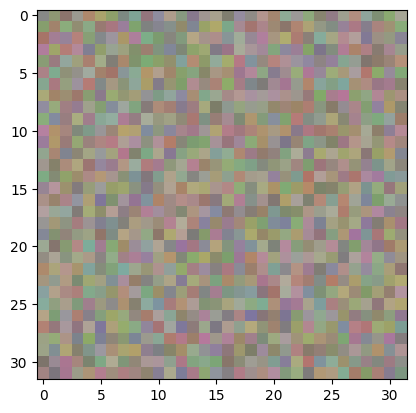

Confidence scores:
plane: 2.6852618165065095e-14
car: 4.55004550746832e-14
bird: 1.7796261686520154e-10
cat: 1.3742774029879001e-08
deer: 4.0506092924275094e-10
dog: 1.0840140634085782e-12
frog: 1.0
horse: 2.362119018179537e-13
ship: 6.758028546866794e-17
truck: 2.0628592963586184e-14
------------------------------------------------------------------------------------------------------------------------
Label with highest confidence score: frog
------------------------------------------------------------------------------------------------------------------------
~~~Attack was successful!~~~


In [26]:
show(generated_sample)
show_probabilities(generated_sample, model_org, classes_org)
separate()
print('~~~Attack was successful!~~~')

### 2.1.2. Attack by using a real image

In [27]:
show_probabilities(testset[13][0], model_org, classes_org)

Confidence scores:
plane: 1.6894080578921944e-09
car: 2.456412850904144e-11
bird: 1.0329271882270064e-09
cat: 2.7005020442061323e-08
deer: 6.924545914444025e-07
dog: 2.862205474229995e-05
frog: 2.7355406828633022e-09
horse: 0.9999706745147705
ship: 8.772247251515042e-13
truck: 3.7917221445971094e-11
------------------------------------------------------------------------------------------------------------------------
Label with highest confidence score: horse


In [28]:
# attack using initial population as testset[0][0] sample with goal of having 'frog' as the output
generated_sample = attack(classes_org, 'frog', model_org, fitness_function=fitness_class_probability, start_population=testset[13][0], early_stopping=True)

Attack finished


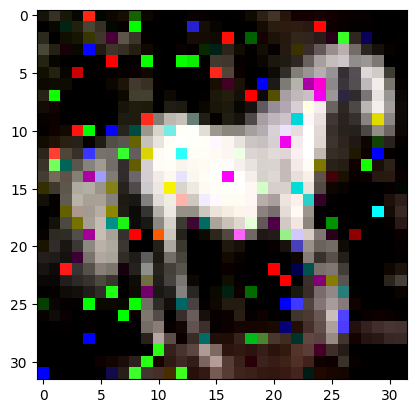

Confidence scores:
plane: 4.865968739053983e-11
car: 1.6179650674796875e-10
bird: 4.170171763462349e-08
cat: 9.642621989769395e-08
deer: 6.18020912224182e-11
dog: 1.2937882709618265e-10
frog: 0.9999998807907104
horse: 2.321353109735469e-10
ship: 1.0986626342577351e-14
truck: 1.3389841457822627e-09
------------------------------------------------------------------------------------------------------------------------
Label with highest confidence score: frog
------------------------------------------------------------------------------------------------------------------------
~~~Attack was successful!~~~


In [29]:
show(generated_sample)
show_probabilities(generated_sample, model_org, classes_org)
separate()
print('~~~Attack was successful!~~~')

In [30]:
# function for calculating pixel-wise difference between two images
def pixel_wise_diff(image1, image2):
    # compare the two images
    difference = np.abs(image1 - image2)

    # count the number of different pixels
    num_diff_pixels = np.count_nonzero(difference)

    # return percentage of different pixels
    return round(100*num_diff_pixels/(image1.size(1)*image1.size(2)),2)

In [ ]:
# select 100 random samples from test set
random_samples = random.sample(list(testset), 100)
differences = []
for image, label in tqdm(random_samples):
    labels = list(classes_org)
    # remove label of class this image belongs to
    labels.remove(classes_org[label])
    # select a label randomly
    random.shuffle(labels)
    selected_class = labels.pop()
    # attack using that target label and target image
    fake_image = attack(classes_org, selected_class, model_org, start_population=image, printing=False)
    differences.append(pixel_wise_diff(image, fake_image))

In [286]:
print('Mean pixel-wise difference between the images is ' + str(round(np.mean(differences),2)) + '%')

Mean pixel-wise difference between the images is 20.29%


# 3. Adversarial defence

## 3.1. Adversarial defence from "noisy" generated images

#### Generating a dataset of adversarial examples (no need to run, can be loaded from noise_data.pt in next section)

In [22]:
# guard from running accidentally
generate_adversarial_dataset = False

if generate_adversarial_dataset:
    if os.path.exists(os.path.join('adversarial_dataset')):
        shutil.rmtree(os.path.join('adversarial_dataset'))
    !mkdir adversarial_dataset

In [30]:
# set number of images to generate per class
numImgsPerClass = 600

In [ ]:
# This took 20 hours to generate
noise_data = []

# for each class generate numImgsPerClass attack images
for aClass in classes_org:
    print('Generating adversarial examples for class: ' + aClass)
    
    for i in tqdm(range(0,numImgsPerClass)):
        generated_img = attack(classes_org, aClass, model_org)
        noise_data.append((torch.Tensor(generated_img), torch.as_tensor(10)))

In [ ]:
if generate_adversarial_dataset:
    # Save the noise data to a file
    torch.save(noise_data, 'adversarial_dataset/noise_data.pt')

### 3.1.1. Method 1: Training on generated adversarial images

#### Creating new dataset with adversarial examples

In [32]:
noise_data = torch.load('adversarial_dataset/noise_data.pt')

In [33]:
# shuffle and split in train and test
random.shuffle(noise_data)
noise_data_train = noise_data[:5000]
noise_data_test = noise_data[5000:]

In [34]:
# obtain CIFAR10 dataset which will be combined with generated dataset
cifar_data_train = []
cifar_data_test = []

for images, labels in trainloader:
    for image, label in zip(images, labels):
        cifar_data_train.append((image, label))
        
for images, labels in testloader:
    for image, label in zip(images, labels):
        cifar_data_test.append((image, label))

In [35]:
# combine datasets
combined_data_train = noise_data_train + cifar_data_train
combined_data_test = noise_data_test + cifar_data_test

In [36]:
# creating DataLoader objects
class CombinedDataset(Dataset):
    def __init__(self, combined_data):
        self.combined_data = combined_data

    def __len__(self):
        return len(self.combined_data)

    def __getitem__(self, idx):
        return self.combined_data[idx]

batch_size = 128
    
combined_dataset_train = CombinedDataset(combined_data_train)
combined_dataset_test = CombinedDataset(combined_data_test)
combined_dataloader_train = DataLoader(combined_dataset_train, batch_size=batch_size, shuffle=True)
combined_dataloader_test = DataLoader(combined_dataset_test, batch_size=batch_size, shuffle=True)

#### Create new model for training

In [37]:
# MobileNetV2 needs to be trained now on 11 classes
classes_adv = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 'generated')

In [38]:
%%capture
model_adv = load_model(classes_adv)
model_adv.to(device)

#### Adversarial training (do not train as it was done and weights are already available in next section)

In [34]:
if os.path.exists(os.path.join('adversarial_weights')):
    shutil.rmtree(os.path.join('adversarial_weights'))
!mkdir adversarial_weights

In [ ]:
train_model(model_adv, combined_dataloader_train, combined_dataloader_test, 'adversarial_weights')

#### Evaluation of adversarially trained model

In [39]:
model_adv = load_weights(classes_adv, model_adv, 'adversarial_weights')

Loaded weights: epoch-80_accuracy-0.793.pth


Using cache found in C:\Users\raulv/.cache\torch\hub\pytorch_vision_v0.10.0


In [40]:
%%capture
model_adv.to(device)
# sets the module in eval node
model_adv.eval()

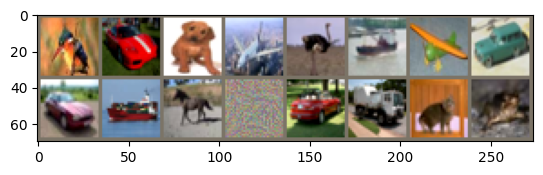

GroundTruth:  bird  car   dog   plane bird  ship  plane car   car   ship  horse generated car   truck cat   frog 
------------------------------------------------------------------------------------------------------------------------
Predicted:    horse car   dog   ship  plane ship  plane car   car   ship  dog   generated car   car   deer  frog 


In [41]:
show_examples(classes_adv, combined_dataloader_test, model_adv)

In [42]:
show_accuracies(classes_adv, combined_dataloader_test, model_adv)
print("\n~~~Overall accuracy is decreased. However, all generated images based on original model are now detected!~~~")

Accuracy for class: plane is 79.6 %
Accuracy for class: car   is 82.3 %
Accuracy for class: bird  is 54.6 %
Accuracy for class: cat   is 36.4 %
Accuracy for class: deer  is 68.3 %
Accuracy for class: dog   is 56.8 %
Accuracy for class: frog  is 80.5 %
Accuracy for class: horse is 74.8 %
Accuracy for class: ship  is 81.8 %
Accuracy for class: truck is 77.5 %
Accuracy for class: generated is 100.0 %
------------------------------------------------------------------------------------------------------------------------
Accuracy on the test set: 72.1%

~~~Overall accuracy is decreased. However, all generated images based on original model are now detected!~~~


#### Attacking using generated images based on original model **(model_org)**

In [43]:
# Generate based on original model
generated_frog = attack(classes_adv, 'frog', model_org)

Attack finished


In [44]:
# Pass images generated on model_org to model_adv for detection. attack no longer works
show_probabilities(generated_frog, model_adv, classes_adv)

Confidence scores:
plane: 7.731812967648466e-10
car: 1.4787902014035126e-09
bird: 2.1510578207539766e-08
cat: 8.428114206537884e-09
deer: 3.533686054879581e-08
dog: 1.3857326397470615e-10
frog: 4.374853233457543e-06
horse: 1.956257725255206e-11
ship: 2.3580991381777494e-08
truck: 8.985415966833443e-09
generated: 0.9999954700469971
------------------------------------------------------------------------------------------------------------------------
Label with highest confidence score: generated


#### Attacking using generated images based on new adversarially trained model **(model_adv)**

In [45]:
# Generate based on new model
generated_frog = attack(classes_adv, 'frog', model_adv)

Attack finished


In [46]:
show_probabilities(generated_frog, model_adv, classes_adv)
separate()
print("~~~Model has been fooled again after it was trained to detect generated images. Newly generated images on model_adv learned to bypass adversarial training!~~~")

Confidence scores:
plane: 2.7370340181871317e-21
car: 8.000629189211303e-17
bird: 6.001825324826736e-17
cat: 7.06970425127032e-14
deer: 1.9167561502976766e-16
dog: 2.408759208177277e-16
frog: 1.0
horse: 3.8249390517600327e-20
ship: 3.220037056319062e-20
truck: 4.018718039745976e-18
generated: 0.0
------------------------------------------------------------------------------------------------------------------------
Label with highest confidence score: frog
------------------------------------------------------------------------------------------------------------------------
~~~Model has been fooled again after it was trained to detect generated images. Newly generated images on model_adv learned to bypass adversarial training!~~~


#### So, adversarial training does not work on images generated using adversarial model. It works only with images generated using original model :(

### 3.1.2. Method 2: Data pre-processing

#### Finding minimum std of pixel regions in image

In [47]:
# function that splits the image in patches, calculates their std and returns minimum std found
def find_min_std(img):
    if isinstance(img, torch.Tensor):
        img = img.numpy()

    # load the image and convert it to grayscale
    image = np.transpose(img, (1, 2, 0))
    image_8u = cv2.convertScaleAbs(image, alpha=255)
    gray_image = cv2.cvtColor(image_8u, cv2.COLOR_BGR2GRAY)

    # define the patch size and overlap
    patch_size = (3, 3)
    overlap = (1, 1)

    # compute the grid of patches
    patches = view_as_windows(gray_image, patch_size, overlap)

    # compute the standard deviation of the pixel intensities in each patch
    patch_stds = np.std(patches, axis=(-1, -2))

    # return the minimum value
    return min(np.array(patch_stds).flatten().tolist())

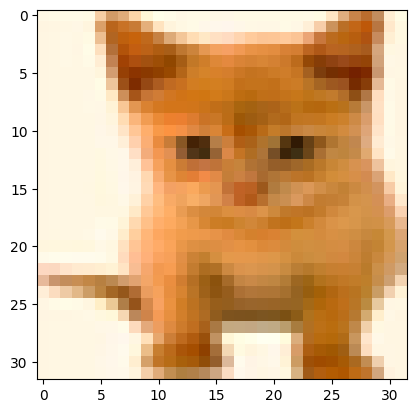

Patch of pixels with smallest std = 0.0


In [48]:
show(cifar_data_test[0][0])
print('Patch of pixels with smallest std =', str(find_min_std(cifar_data_test[0][0])))

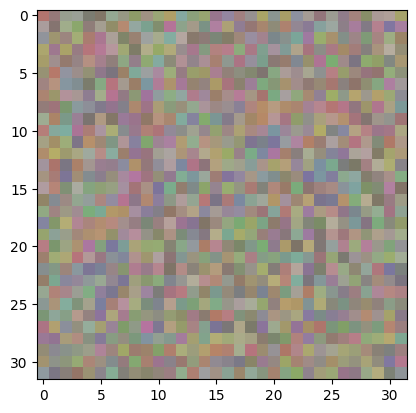

Patch of pixels with smallest std = 15.412837362262522


In [49]:
show(noise_data[0][0])
print('Patch of pixels with smallest std =', str(find_min_std(noise_data[0][0])))

In [50]:
stds = []
for data in cifar_data_train+cifar_data_test:
    stds.append(find_min_std(data[0]))

print('Minimum min std of all samples in CIFAR10 dataset: ' + str(min(stds)))
print('Maximum min std of all samples in CIFAR10 dataset: ' + str(max(stds)))
separate()

stds = []
for data in noise_data:
    stds.append(find_min_std(data[0]))

print('Minimum min std of all samples in noise_data: ' + str(min(stds)))
print('Maximum min std of all samples in noise_data: ' + str(max(stds)))

Minimum min std of all samples in CIFAR10 dataset: 0.0
Maximum min std of all samples in CIFAR10 dataset: 13.314801936840215
------------------------------------------------------------------------------------------------------------------------
Minimum min std of all samples in noise_data: 3.8999841721742765
Maximum min std of all samples in noise_data: 24.632609120813115


In [51]:
# threshold based on results above
threshold_for_find_min_std = 3.0

In [52]:
print(str(round(100-100*len([1 for data in cifar_data_train+cifar_data_test if find_min_std(data[0])<threshold_for_find_min_std])/60000, 2))+
      '% samples from CIFAR10 are going to be incorrectly labeled as generated by data pre-processing. Good separation')

0.75% samples from CIFAR10 are going to be incorrectly labeled as generated by data pre-processing. Good separation


In [53]:
# custom model class that makes use of find_min_std() function
class CustomMobileNetV2(torch.nn.Module):
    def __init__(self):
        super(CustomMobileNetV2, self).__init__()
        self.model = load_model(classes_org)
        self.model = load_weights(classes_org, self.model, 'weights')
        
    def forward(self, x):
        # pass the image through the model and return the predicted label
        with torch.no_grad():
            logits = self.model(x)
            
            # create a tensor of -1000 with shape (batch_size,1)
            generated_label = torch.full((x.shape[0],1),-1000,dtype=x.dtype, device=device)

            # concatenate the logits and generated_label along the second dimension
            logits = torch.cat((logits, generated_label), dim=1)

            # apply find_min_std() to all samples in the batch
            for i in range(x.shape[0]):
                min_std = find_min_std(x[i].squeeze(0).cpu())
                if min_std > threshold_for_find_min_std:
                    # return a tensor which has highest probability as being generated sample
                    logits[i] = torch.tensor([-1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, 1], dtype=x.dtype, device=device)

            return logits

In [54]:
%%capture
# wrap the model in a CustomModel object
model_preprocessing = CustomMobileNetV2()
model_preprocessing.to(device)
model_preprocessing.eval()

In [55]:
# generate based on original model
generated_frog_org = attack(classes_adv, 'frog', model_org)

Attack finished


In [56]:
# generate based on adversarially trained model
generated_frog_adv = attack(classes_adv, 'frog', model_adv)

Attack finished


In [57]:
print('Results for a real image:')
show_probabilities(images[0], model_preprocessing, classes_adv)
separate()
print('\nResults for generated image on model_org:')
show_probabilities(generated_frog_org, model_preprocessing, classes_adv)
separate()
print('\nResults for generated image on model_adv:')
show_probabilities(generated_frog_adv, model_preprocessing, classes_adv)
separate()
print('\n~~~Data pre-processing manages to find generated adversarial images based on both model_org and model_adv!~~~')

Results for a real image:
Confidence scores:
plane: 0.06148364394903183
car: 0.0004600405809469521
bird: 0.0012334699276834726
cat: 0.06585497409105301
deer: 0.0021648816764354706
dog: 0.0605451762676239
frog: 3.3676922612357885e-05
horse: 0.8064049482345581
ship: 0.00036770058795809746
truck: 0.0014514561044052243
generated: 0.0
------------------------------------------------------------------------------------------------------------------------
Label with highest confidence score: horse
------------------------------------------------------------------------------------------------------------------------

Results for generated image on model_org:
Confidence scores:
plane: 0.0
car: 0.0
bird: 0.0
cat: 0.0
deer: 0.0
dog: 0.0
frog: 0.0
horse: 0.0
ship: 0.0
truck: 0.0
generated: 1.0
------------------------------------------------------------------------------------------------------------------------
Label with highest confidence score: generated
--------------------------------------

In [58]:
show_accuracies(classes_adv, combined_dataloader_test, model_preprocessing)

Accuracy for class: plane is 86.8 %
Accuracy for class: car   is 91.9 %
Accuracy for class: bird  is 75.0 %
Accuracy for class: cat   is 65.2 %
Accuracy for class: deer  is 76.6 %
Accuracy for class: dog   is 79.1 %
Accuracy for class: frog  is 84.4 %
Accuracy for class: horse is 84.2 %
Accuracy for class: ship  is 90.3 %
Accuracy for class: truck is 91.5 %
Accuracy for class: generated is 100.0 %
------------------------------------------------------------------------------------------------------------------------
Accuracy on the test set: 84.1%


#### Will genetic algorithm bypass model with data pre-processing model when it is attacked directly?

In [59]:
# generate based on data pre-processing model
generated_frog = attack(classes_adv, 'frog', model_preprocessing)

Attack finished


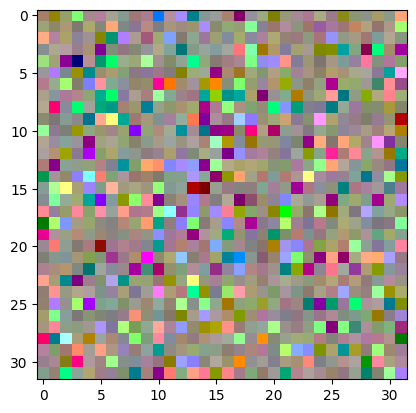

Confidence scores:
plane: 0.0
car: 0.0
bird: 0.0
cat: 0.0
deer: 0.0
dog: 0.0
frog: 0.0
horse: 0.0
ship: 0.0
truck: 0.0
generated: 1.0
------------------------------------------------------------------------------------------------------------------------
Label with highest confidence score: generated


In [60]:
show(generated_frog)
show_probabilities(generated_frog, model_preprocessing, classes_adv)

In [61]:
def generate_eval_data(classes, model, dataset_name, start_population):
    # we care about targeted attacks so when class is wrong it is TN
    
    # select 500 random samples from test set
    random_samples = random.sample(list(testset), 500)
    
    # real images get label 1
    real_images = [(image, 1) for image, label in random_samples]
    
    # store actual labels to not target class image belongs to
    real_labels = [label for image, label in random_samples]
    fake_images = []
    
    # if random initial population attack else target initial population
    if not start_population:
        for i in tqdm(range(len(real_images))):
            # choose a target label randomly, should not be "generated"
            fake_label = random.choice(classes[:10])
            # attack using that target label
            fake_image = attack(classes, fake_label, model, printing=False)
            # save the generated image
            fake_images.append((torch.Tensor(fake_image), 0))
    else:
        for i, (image, label) in enumerate(tqdm(real_images)):            
            # attack label should not be "generated"
            labels = list(classes[:10])
            # remove label of class this image belongs to
            labels.remove(classes[real_labels[i]])
            # select a label randomly
            random.shuffle(labels)
            selected_class = labels.pop()
            # attack using that target label and target image
            fake_image = attack(classes, selected_class, model, start_population=image, printing=False)
            # save the generated image
            fake_images.append((torch.Tensor(fake_image), 0))

    # combine real and fake with labels, shuffle and save 
    all_images = real_images + fake_images
    random.shuffle(all_images)
    torch.save(all_images, os.path.join('evaluation_dataset', dataset_name + '.pt'))    

In [380]:
if os.path.exists(os.path.join('evaluation_dataset')):
    shutil.rmtree(os.path.join('evaluation_dataset'))
!mkdir evaluation_dataset

In [381]:
generate_eval_data(classes_adv, model_preprocessing, dataset_name='pre-processing', start_population=False)

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [7:48:00<00:00, 56.16s/it]


In [62]:
pre_processing_eval_dataset = torch.load('evaluation_dataset/pre-processing.pt')

In [63]:
def evaluate_data(eval_dataset, model):
    tp, fp, fn, tn = 0, 0, 0, 0
    for image, label in eval_dataset:
        # calculate number of TP, TN, FP, FN
        _, res = torch.max(model(image.float().unsqueeze(0).to(device)),1)
        if label==0 and res.item()==10:
            tp += 1
        elif label==0:
            # for randomization model if GA image is unaltered,
            # it cannot be detected as generated, instead it is
            # classified as normal image. therefore, this check it
            for image1, label1 in eval_dataset:
                if label1==0:
                    continue
                else:
                    # checking if pixel difference is 0
                    result = pixel_wise_diff(image1, image)
                    if result == 0:
                        # if image is unaltered, it is TP
                        tp += 1
                        break
            else: 
                #show(image)
                fn += 1
        elif label==1 and res.item()==10:
            fp += 1
        elif label==1:
            tn += 1

    confusion_matrix = np.array([[tp, fp], [fn, tn]])
    
    # create a heatmap using imshow()
    plt.imshow(confusion_matrix, cmap='Blues')

    # add labels to the x-axis
    plt.xlabel('Predicted', labelpad=-300)
    plt.xticks([0, 1], ['Real', 'Generated'])

    # add labels to the y-axis
    plt.ylabel('Actual')
    plt.yticks([0, 1], ['Real', 'Generated'])

    # add values to the cells
    for i in range(2):
        for j in range(2):
            plt.text(j, i, confusion_matrix[i, j], ha='center', va='center', color='green',size=15)
  
    # move the x-axis to the top
    plt.gca().xaxis.set_ticks_position('top')
    plt.gca().xaxis.tick_top()
    #plt.savefig("./plt.png")
    plt.show()

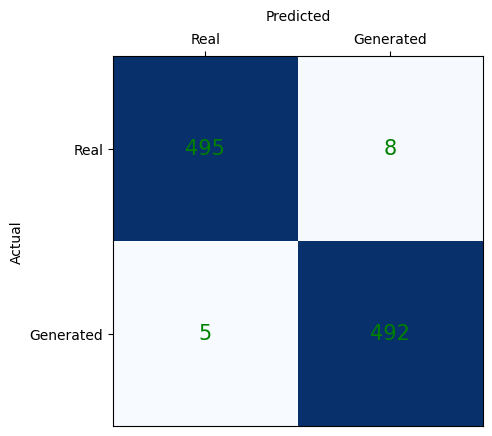

In [64]:
evaluate_data(pre_processing_eval_dataset, model_preprocessing)

#### Genetic algorithm takes longer to find a solution. In most of the cases, it is unable to arrive to an optimal solution.
#### Defence was successfull!

# 3.2. Adversarial defence from real looking generated images

## 3.2.1. Method: Using randomized data augmentation at the input of the network

In [65]:
# function that randomly rotates and flips batch of input images
def random_rotate_and_flip(images):
    out_images = np.zeros(images.shape)
    batch_size, _, _, _ = images.shape
    for i in range(batch_size):
        image = images[i]
        #show(image)
        image = np.transpose(image, (1, 2, 0))

        # randomly rotate the image and extend it on edges if needed
        angle = np.random.randint(0, 360)
        image = rotate(image, angle, reshape=False, mode='nearest')
        
        # randomly flip image horizontally or vertically
        flip_axis = np.random.randint(0, 2)
        if flip_axis == 0:
            image = cv2.flip(image, 0)
        else:
            image = cv2.flip(image, 1)

        image = np.transpose(image, (2, 0, 1))    
        out_images[i] = image
        #show(image)
    return out_images


In [66]:
stds = []
for data in cifar_data_train+cifar_data_test:
    stds.append(np.std(data[0].numpy()))

print('Minimum std of all samples in CIFAR10 dataset: ' + str(min(stds)))
print('Maximum std of all samples in CIFAR10 dataset: ' + str(max(stds)))

# noise tends to have higher values of std, so upper bound (maximum) will be used in model

Minimum std of all samples in CIFAR10 dataset: 0.25320393
Maximum std of all samples in CIFAR10 dataset: 2.3717947


In [67]:
# threshold based on results above
threshold_for_max_std = 2.4

In [68]:
# custom model class which uses random_rotate_and_flip() and find_min_std() functions
class CustomMobileNetV2_randomize(torch.nn.Module):
    def __init__(self):
        super(CustomMobileNetV2_randomize, self).__init__()
        self.model = load_model(classes_org)
        
    def load(self):
        self.model = load_weights(classes_org, self.model, 'randomization_weights')

    def forward(self, x):
        # training is done with 10 original classes
        if self.model.training:
            x = torch.Tensor(random_rotate_and_flip(x.cpu().numpy())).to(device)
            x = self.model(x)
            
            return x
        # evaluation is done using extra "generated" class
        else:
            with torch.no_grad():
                x = torch.Tensor(random_rotate_and_flip(x.cpu().numpy())).to(device)
                logits = self.model(x)

                # create a tensor of -1000 with shape (batch_size,1)
                generated_label = torch.full((x.shape[0],1),-1000,dtype=x.dtype, device=device)

                # concatenate the logits and generated_label along the second dimension
                logits = torch.cat((logits, generated_label), dim=1)

                for i in range(x.shape[0]):
                    max_std = np.std(x[i].squeeze(0).cpu().numpy())
                    min_std = find_min_std(x[i].squeeze(0).cpu())

                    # if total std or min std of patches is too large, reject image as generated
                    if max_std > threshold_for_max_std or min_std > threshold_for_find_min_std:
                        logits[i] = torch.tensor([-1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, 1], dtype=x.dtype, device=device)

                return logits

In [69]:
%%capture
model_randomize = CustomMobileNetV2_randomize()
model_randomize.to(device)

#### Training of the randomizing data augmentation model (no need to do again, load weights from next section)

In [1162]:
if os.path.exists(os.path.join('randomization_weights')):
    shutil.rmtree(os.path.join('randomization_weights'))
!mkdir randomization_weights

In [ ]:
train_model(model_randomize, trainloader, testloader, 'randomization_weights', num_epochs=200)

#### Evaluation of the randomizing data augmentation model

In [70]:
# method had to be implemented to call load_weights from within the class
model_randomize.load()

Using cache found in C:\Users\raulv/.cache\torch\hub\pytorch_vision_v0.10.0


Loaded weights: epoch-150_accuracy-0.733.pth


In [71]:
%%capture
model_randomize.eval()
model_randomize.to(device)

In [72]:
show_accuracies(classes_org, testloader, model_randomize)
separate()
print('Decreased accuracy, but it was expected given that training and test images keep changing at input')

Accuracy for class: plane is 77.5 %
Accuracy for class: car   is 86.6 %
Accuracy for class: bird  is 64.0 %
Accuracy for class: cat   is 63.5 %
Accuracy for class: deer  is 67.9 %
Accuracy for class: dog   is 66.1 %
Accuracy for class: frog  is 76.7 %
Accuracy for class: horse is 76.8 %
Accuracy for class: ship  is 80.5 %
Accuracy for class: truck is 80.0 %
------------------------------------------------------------------------------------------------------------------------
Accuracy on the test set: 74.0%
------------------------------------------------------------------------------------------------------------------------
Decreased accuracy, but it was expected given that training and test images keep changing at input


In [73]:
generated_sample = attack(classes_adv, 'frog', model_randomize, fitness_function=fitness_class_probability, start_population=testset[13][0])

Attack finished


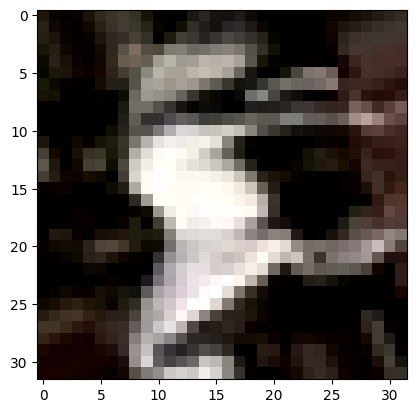

Confidence scores:
plane: 0.003698128741234541
car: 0.021458229050040245
bird: 0.05559355393052101
cat: 0.12177249789237976
deer: 0.023293275386095047
dog: 0.013045898638665676
frog: 0.00029728561639785767
horse: 0.753650963306427
ship: 7.677593384869397e-05
truck: 0.007113409694284201
generated: 0.0
------------------------------------------------------------------------------------------------------------------------
Label with highest confidence score: horse


In [74]:
# first show real sample and it's classification probabilities
# note: probablity changes on runs due to randomization CNN adds now
show(torch.Tensor(random_rotate_and_flip(testset[13][0].unsqueeze(0).numpy())).squeeze())
show_probabilities(testset[13][0], model_randomize, classes_adv)

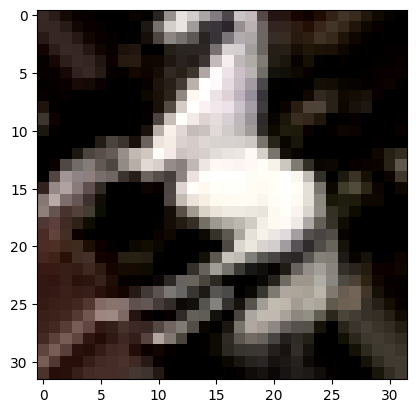

Confidence scores:
plane: 0.001808495493605733
car: 0.020471695810556412
bird: 0.07812423259019852
cat: 0.11329683661460876
deer: 0.018243057653307915
dog: 0.022562626749277115
frog: 0.00025113343144766986
horse: 0.7377004623413086
ship: 0.00012346453149802983
truck: 0.007417985238134861
generated: 0.0
------------------------------------------------------------------------------------------------------------------------
Label with highest confidence score: horse


In [75]:
# now show generated sample and it's classification probabilities. GA fails to do any successfull attack
# and, hence, the image is unchanged
show(torch.Tensor(random_rotate_and_flip(torch.Tensor(generated_sample).unsqueeze(0))).squeeze())
show_probabilities(generated_sample, model_randomize, classes_adv)

In [387]:
generate_eval_data(classes_adv, model_randomize, dataset_name='randomize', start_population=True)

100%|████████████████████████████████████████████████████████████████████████████| 500/500 [20:06:23<00:00, 144.77s/it]


In [76]:
randomize_eval_dataset = torch.load('evaluation_dataset/randomize.pt')

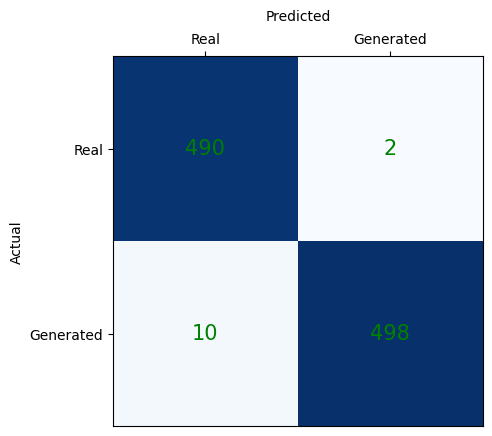

In [82]:
evaluate_data(randomize_eval_dataset, model_randomize)

#### Thus, genetic algorithm is no longer able to alter target image in a way that attacks the network. It simply does not do anything due to even worse generations resulting from it.
#### Defence was successfull!

# 4. Attempted but with not good results

## 4.1. Method 1: Denosing of pathes

In [837]:
# function which splits the image in patches, applies median filter and reconstructs it
# was found to filter out pixels added to images but accuracy decreases. also prone to direct attacks
def denoise_patches(img):
    if isinstance(img, torch.Tensor):
        img = img.squeeze().cpu().numpy()
    
    # load the image
    img = np.transpose(img, (1, 2, 0))

    # extract patches from the image
    patch_size = (2, 2)
    patches = image_skl.extract_patches_2d(img, patch_size)

    # apply median blur filter to patches
    denoised_patches = np.asarray([cv2.medianBlur(patch, 3) for patch in patches])

    # reconstruct the denoised image from the patches
    reconstructed_image = image_skl.reconstruct_from_patches_2d(denoised_patches, (32, 32, 3))

    return torch.tensor(np.transpose(reconstructed_image, (2, 0, 1)))

In [638]:
generated_sample = attack(classes_org, 'frog', model_org, fitness_function=fitness_class_probability, start_population=testset[9][0])

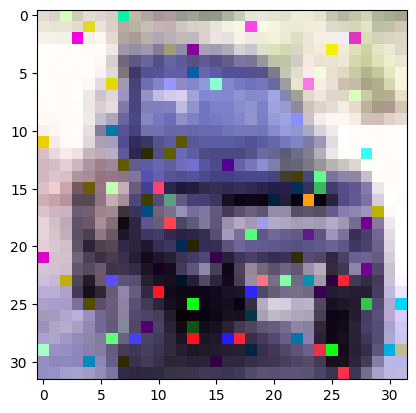

In [838]:
show(generated_sample)

In [640]:
_, res = torch.max(model_preprocessing(torch.Tensor(generated_sample).unsqueeze(0).to(device)),1)
print('Classification: ' + classes_adv[res.item()])

Classification: frog


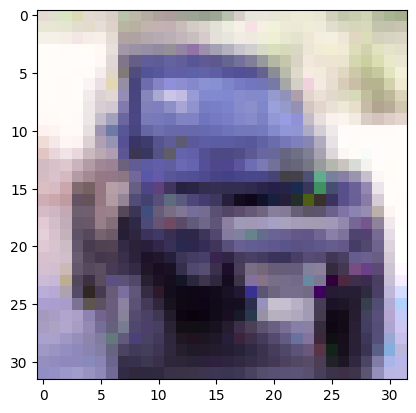

In [839]:
show(denoise_patches(generated_sample))

In [649]:
_, res = torch.max(model_org(torch.Tensor(denoise_patches(generated_sample)).float().unsqueeze(0).to(device)),1)
print('Classification: ' + classes_adv[res.item()])

Classification: car


In [682]:
# custom model that was created to use denoise_patches() function
class CustomMobileNetV2_real(torch.nn.Module):
    def __init__(self):
        super(CustomMobileNetV2_real, self).__init__()
        self.model = load_model(classes_org)

    def forward(self, x):
        for i in range(x.shape[0]):
            x[i] = denoise_patches(x[i].squeeze(0).cpu())
        x = self.model(x)
        return x


## 4.2. Method 2: Adversarial training

In [670]:
# generates a dataset of real looking images with attack pixels added
def generateDataset(dataset, classes, numImgsPerClass):
    # this took 20 hours to generate for trainset
    noise_data_real = []
    unused_idx = list(range(0,len(dataset)))

    for aClass in classes:
        print('Generating adversarial examples for class: ' + aClass)

        # make sure image that is being attacked does not get assigned the label it is already
        for i in tqdm(range(0,numImgsPerClass)):
            random_img_idx = 0
            while True:
                random_img_idx = random.choice(unused_idx)
                if dataset[random_img_idx][1] != classes.index(aClass):
                    unused_idx.remove(random_img_idx)
                    break

            generated_img = attack(classes, aClass, model_org, fitness_function=fitness_class_probability, start_population=dataset[random_img_idx][0])
            noise_data_real.append((torch.Tensor(generated_img), torch.as_tensor(dataset[random_img_idx][1])))
            
    return noise_data_real, unused_idx

In [554]:
noise_data_real_train, unused_idx_train = generateDataset(dataset=trainset, classes=classes_org, numImgsPerClass=600)

In [616]:
cifar_cut_trainset = []
for i, (image, label) in enumerate(trainset):
    if i in unused_idx_train:
        cifar_cut_trainset.append((image, torch.as_tensor(label)))

In [680]:
#combined_dataset_train_real = CombinedDataset(cifar_cut_trainset+noise_data_real_train)
#torch.save(combined_dataset_train_real, 'adversarial_dataset/combined_dataset_train_real.pt')
combined_dataset_train_real = torch.load('adversarial_dataset/combined_dataset_train_real.pt')
combined_dataloader_train_real = DataLoader(combined_dataset_train_real, batch_size=batch_size, shuffle=True)

In [673]:
noise_data_real_test, unused_idx_test = generateDataset(dataset=testset, classes=classes_org, numImgsPerClass=120)

Generating adversarial examples for class: plane


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [24:44<00:00, 12.37s/it]


Generating adversarial examples for class: car


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [24:37<00:00, 12.31s/it]


Generating adversarial examples for class: bird


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [24:43<00:00, 12.36s/it]


Generating adversarial examples for class: cat


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [24:35<00:00, 12.29s/it]


Generating adversarial examples for class: deer


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [24:40<00:00, 12.34s/it]


Generating adversarial examples for class: dog


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [24:41<00:00, 12.35s/it]


Generating adversarial examples for class: frog


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [24:43<00:00, 12.37s/it]


Generating adversarial examples for class: horse


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [24:16<00:00, 12.14s/it]


Generating adversarial examples for class: ship


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [24:41<00:00, 12.35s/it]


Generating adversarial examples for class: truck


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [24:43<00:00, 12.37s/it]


In [675]:
cifar_cut_testset = []
for i, (image, label) in enumerate(testset):
    if i in unused_idx_test:
        cifar_cut_testset.append((image, torch.as_tensor(label)))

In [750]:
#combined_dataset_test_real = CombinedDataset(cifar_cut_testset+noise_data_real_test)
#torch.save(combined_dataset_test_real, 'adversarial_dataset/combined_dataset_test_real.pt')
combined_dataset_test_real = torch.load('adversarial_dataset/combined_dataset_test_real.pt')
combined_dataloader_test_real = DataLoader(combined_dataset_test_real, batch_size=batch_size, shuffle=True)

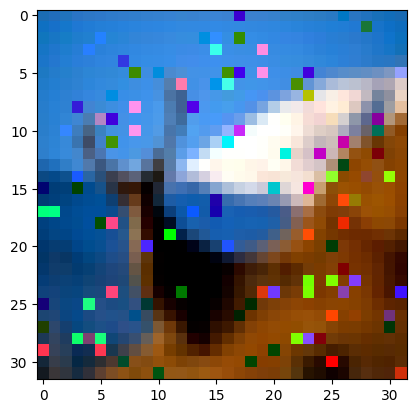

In [751]:
show(combined_dataset_test_real[-2][0])

## 4.3. Other...

In [156]:
# this was an alternative to find_min_std() which instead looks at frequencies present in the image
def frequency_domain_detection(image: torch.Tensor) -> float:
    # convert the image to numpy array
    image = image.numpy().transpose(1,2,0)
    image_8u = cv2.convertScaleAbs(image, alpha=255)

    # convert image to grayscale
    gray_image = cv2.cvtColor(image_8u, cv2.COLOR_RGB2GRAY)
    # perform FFT on grayscale image
    fft_image = np.fft.fft2(gray_image)
    # shift the FFT to center
    fft_image = np.fft.fftshift(fft_image)
    # calculate the mean of the magnitude
    std = np.std(np.abs(fft_image))
    return std